## Object Detection System 만들기

In [1]:
import os, copy
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

In [2]:
DATA_PATH = '/mnt/disk2/tensorflow_datasets'

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir=DATA_PATH,
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

2022-09-03 00:02:40.883236: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-03 00:02:40.928179: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-03 00:02:40.928415: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-03 00:02:40.929577: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

KITTI  데이터셋은 
- 6,347개의 학습 데이터(training data)
- 423개의 검증용 데이터(validation data)
- 711개의 평가용 데이터(test data)

라벨에는 alpha, bbox, dimensions, location, occluded, rotation_y, truncated 등의 정보가 있음

In [4]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/mnt/disk2/tensorflow_datasets/kitti/3.2.0',
    file_format=tfrecord,
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha

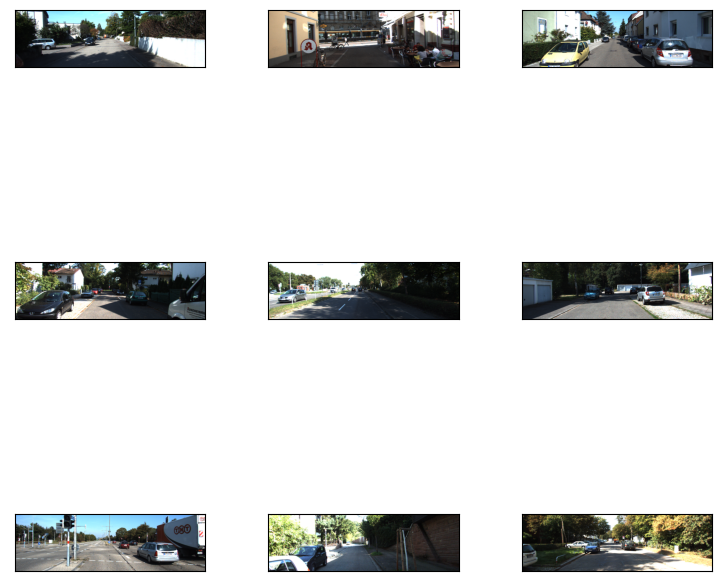

In [5]:
_ = tfds.show_examples(ds_train, ds_info)

### 데이터 직접 확인하기

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(11,), dtype=float32, numpy=
array([-0.5 , -2.06,  2.52,  2.55,  3.08,  2.94,  2.74,  2.6 ,  2.18,
        2.56, -1.56], dtype=float32)>, 'bbox': <tf.Tensor: shape=(11, 4), dtype=float32, numpy=
array([[0.33543244, 0.8987092 , 0.6204054 , 0.99662584],
       [0.42378378, 0.7983415 , 0.5999189 , 0.8176961 ],
       [0.0027027 , 0.        , 0.6941622 , 0.1906781 ],
       [0.0027027 , 0.        , 0.74445945, 0.12280229],
       [0.31835136, 0.5864543 , 0.56943244, 0.6180556 ],
       [0.37116218, 0.6998203 , 0.5861081 , 0.7720261 ],
       [0.3888108 , 0.93093956, 0.6155135 , 0.999183  ],
       [0.29718918, 0.8468954 , 0.61635137, 0.8826389 ],
       [0.26545945, 0.8674837 , 0.6504054 , 0.90389705],
       [0.28835136, 0.8601144 , 0.59162164, 0.88631535],
       [0.5081081 , 0.4827941 , 0.56632435, 0.498366  ]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(11, 3), dtype=float

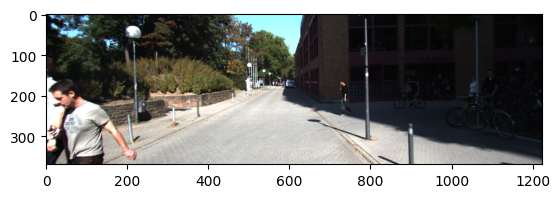

In [6]:
sample = ds_train.take(1)

for example in sample:  
    print('------Example------')
    print(list(example.keys()))
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
plt.imshow(img)
plt.show()

[[0.33543244 0.8987092  0.6204054  0.99662584]
 [0.42378378 0.7983415  0.5999189  0.8176961 ]
 [0.0027027  0.         0.6941622  0.1906781 ]
 [0.0027027  0.         0.74445945 0.12280229]
 [0.31835136 0.5864543  0.56943244 0.6180556 ]
 [0.37116218 0.6998203  0.5861081  0.7720261 ]
 [0.3888108  0.93093956 0.6155135  0.999183  ]
 [0.29718918 0.8468954  0.61635137 0.8826389 ]
 [0.26545945 0.8674837  0.6504054  0.90389705]
 [0.28835136 0.8601144  0.59162164 0.88631535]
 [0.5081081  0.4827941  0.56632435 0.498366  ]]
[[1100.02     245.89    1219.87     140.45001]
 [ 977.17     213.2     1000.86005  148.03   ]
 [   0.       369.       233.39     113.16   ]
 [   0.       369.       150.31      94.55002]
 [ 717.82     252.20999  756.50006  159.31   ]
 [ 856.58     232.67     944.95996  153.14001]
 [1139.47     226.14    1223.       142.26001]
 [1036.6      260.04    1080.35     141.95   ]
 [1061.8      271.78    1106.37     129.35   ]
 [1052.78     263.31    1084.85     151.09999]
 [ 590.94   

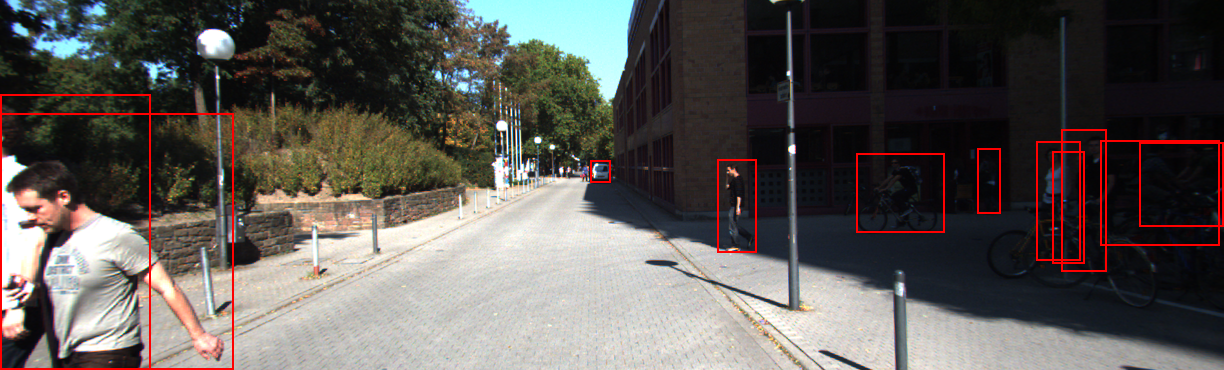

In [7]:
# 이미지 위에 바운딩 박스를 그려 화면에 표시해 주세요.
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)
    
    print(object_bbox)

    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = input_image.size
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height

    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    print(rects)
    for _rect in rects:
        draw.rectangle(_rect, outline=(255,0,0), width=2)

    return input_image

visualize_bbox(img, objects['bbox'].numpy())

### RetinaNet

RetinaNet은 Focal Loss for Dense Object Detection 논문을 통해 공개된 detection 모델
- Focal Loss 와 FPN(Feature Pyramid Network) 를 적용한 네트워크를 사용

#### Focal Loss

- 물체를 배경보다 더 잘 학습하자
  - 대부분의 이미지에서 물체보다 배경이 많다.
  - 따라서 이미지는 극단적으로 배경의 class가 많은 class imbalanced data 라고 할 수 있다.
  - 이렇게 너무 많은 배경 class 에 압도되지 않도록 modulating factor 로 손실을 조절한다.
- 물체인 경우 Loss 를 작게 만들자
  - γ (gamma) 를 0으로 설정하면 modulating factor (1-Pt)^γ 가 1 이 되어 일반적인 교차 엔트로피가 되고
  - γ가 커질수록 modulating이 강하게 적용되는 것

#### FPN(Feature Pyramid Network)

- 특성을 피라미드처럼 쌓아서 사용하는 방식
  - 입력 이미지와 가까운 앞쪽 레이어의 특성맵일수록 좁은 범위의 정보를 담고 있다.
  - 레이어가 깊어질수록 넓은 범위의 정보를 갖게 된다.
  - 이를 receptive field 라고 한다.

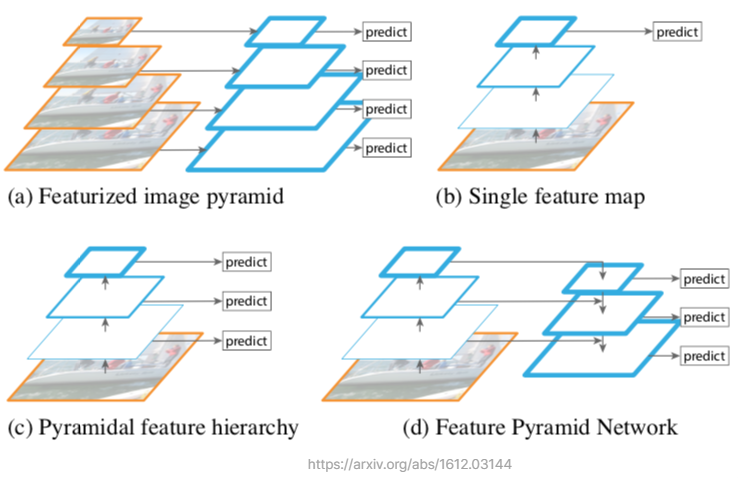

In [8]:
from IPython.display import Image
Image(filename='capture/fpn.png') 

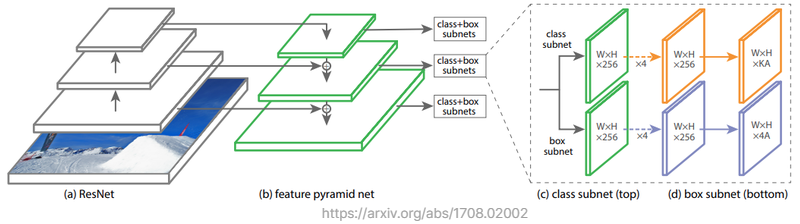

In [9]:
from IPython.display import Image
Image(filename='capture/fpn_2.png') 

- 각 피라미드 레벨은 256개의 채널로 구성
- 이를 가지고 class subnet (classification용) 과 box subnet (box regression용) 을 구성
  - anchor 개수가 A 면 ---> class subnet 은 KA 개 채널, box subnet 은 4A 개 채널을 사용함

### 데이터 준비

이미지 변환 함수

(1) x 와 y 좌표 위치 교체

In [10]:
def swap_xy(boxes):
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)

(2) 무작위로 수평 뒤집기(Flip)

In [11]:
def random_flip_horizontal(image, boxes):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack(
           [1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1
        )
        
    return image, boxes

(3) 이미지 크기 조정 및 패딩 추가

In [12]:
def resize_and_pad_image(image, training=True):

    # 이미지의 비율은 그대로 유지되어야 하고, 이미지의 최대/최소 크기도 제한해야 함
    min_side = 800.0
    max_side = 1333.0
    min_side_range = [640, 1024]
    stride = 128.0
    # 예를 들어 600x720 크기의 이미지가 있다면 800x960 크기로 바꿀 수 있습니다.
    # 여기에 stride를 128로 놓아 800x960 크기의 이미지에 패딩을 더해 896x1024 크기의 이미지로 모델에 입력하겠다는 이야기
    # 모델에 입력되는 이미지에는 검정 테두리가 있음
    
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    if training:
        min_side = tf.random.uniform((), min_side_range[0], min_side_range[1], dtype=tf.float32)
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )
    return image, image_shape, ratio

(4) 좌표계 수정  
좌표계를 [x_min, y_min, x_max, y_max]에서 [x_min, y_min, width, height]으로 수정하는 함수

In [13]:
def convert_to_xywh(boxes):
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )

#### 전처리 함수

In [14]:
def preprocess_data(sample):
    image = sample["image"]
    bbox = swap_xy(sample["objects"]["bbox"])
    class_id = tf.cast(sample["objects"]["type"], dtype=tf.int32)

    image, bbox = random_flip_horizontal(image, bbox)
    image, image_shape, _ = resize_and_pad_image(image)

    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)
    return image, bbox, class_id

#### AnchorBox 생성 함수

In [15]:
class AnchorBox:
    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]

        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(3, 8)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1]
        )
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(3, 8)
        ]
        return tf.concat(anchors, axis=0)

#### 입력할 데이터를 Anchor Box 에 맞게 변경

IoU 계산 함수

In [16]:
def convert_to_corners(boxes):
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )

def compute_iou(boxes1, boxes2):
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)

실제 라벨을 Anchor Box 에 맞춰주는 클래스
- 위에서 만든 compute_iou 함수를 이용해서 IoU 를 구하고
- 그 IoU 를 기준으로 물체에 해당하는 Anchor Box 와 배경이 되는 Anchor Box 를 지정
- 그 Anchor Box 와 실제 Bounding Box 와의 미세한 차이를 계산
  - 상하좌우 차이, 가로세로 크기의 차이

In [17]:
class LabelEncoder:

    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4
    ):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        positive_mask = tf.greater_equal(max_iou, match_iou)
        negative_mask = tf.less(max_iou, ignore_iou)
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        return batch_images, labels.stack()

### Feature Pyramid

In [18]:
class FeaturePyramid(tf.keras.layers.Layer):

    def __init__(self, backbone):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid")
        self.backbone = backbone
        self.conv_c3_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.conv_c7_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = tf.keras.layers.UpSampling2D(2)

    def call(self, images, training=False):
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        return p3_output, p4_output, p5_output, p6_output, p7_output

#### head 만드는 함수

Object Detection 의 라벨은 class 와 box 로 이루어지므로 각각을 추론해야 함
- 이를 head 라고 부르기도 함

Backbone 과 FPN 을 통해 Pyramid Layer 가 추출되고 나면 -> 그 feature 들을 바탕으로 -> class 와 box 예상

*class 를 예측하는 head 와, box 를 예측하는 head 가 각각 존재*

In [19]:
def build_head(output_filters, bias_init):
    head = tf.keras.Sequential([tf.keras.Input(shape=[None, None, 256])])
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    for _ in range(4):
        head.add(
            tf.keras.layers.Conv2D(256, 3, padding="same", kernel_initializer=kernel_init)
        )
        head.add(tf.keras.layers.ReLU())
    head.add(
        tf.keras.layers.Conv2D(
            output_filters,
            3,
            1,
            padding="same",
            kernel_initializer=kernel_init,
            bias_initializer=bias_init,
        )
    )
    return head

ResNet50을 쓰는 RetinaNet의 backbone 생성

In [20]:
def get_backbone():
    backbone = tf.keras.applications.ResNet50(
        include_top=False, input_shape=[None, None, 3]
    )
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
    ]
    return tf.keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )

### RetinaNet 완성하기

Backbone + FPN + classification용 head + box용 head

In [21]:
class RetinaNet(tf.keras.Model):

    def __init__(self, num_classes, backbone):
        super(RetinaNet, self).__init__(name="RetinaNet")
        self.fpn = FeaturePyramid(backbone)
        self.num_classes = num_classes

        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        self.cls_head = build_head(9 * num_classes, prior_probability)
        self.box_head = build_head(9 * 4, "zeros")

    def call(self, image, training=False):
        features = self.fpn(image, training=training)
        N = tf.shape(image)[0]
        cls_outputs = []
        box_outputs = []
        for feature in features:
            box_outputs.append(tf.reshape(self.box_head(feature), [N, -1, 4]))
            cls_outputs.append(
                tf.reshape(self.cls_head(feature), [N, -1, self.num_classes])
            )
        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        return tf.concat([box_outputs, cls_outputs], axis=-1)

### Loss 준비

Focal Loss
- Classification Loss 만 계산 (Box Regress 에서는 사용하지 않음)

Smooth L1 Loss
- Box Regression 에 사용

In [22]:
class RetinaNetBoxLoss(tf.losses.Loss):

    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetClassificationLoss(tf.losses.Loss):

    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetLoss(tf.losses.Loss):

    def __init__(self, num_classes=8, alpha=0.25, gamma=2.0, delta=1.0):
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        )
        cls_predictions = y_pred[:, :, 4:]
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)
        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        clf_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, clf_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        loss = clf_loss + box_loss
        return loss

### 모델 학습

In [23]:
num_classes = 8
batch_size = 2

resnet50_backbone = get_backbone()
loss_fn = RetinaNetLoss(num_classes)
model = RetinaNet(num_classes, resnet50_backbone)

learning rate 설정
- 논문에서는 8개 GPU 사용
- 각자 환경에 맞게 적절히 변경

Optimizer
- 논문과 동일하게 SGD 사용

In [24]:
learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]
learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries, values=learning_rates
)
optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)
model.compile(loss=loss_fn, optimizer=optimizer)

데이터 전처리를 위한 파이프라인

In [25]:
label_encoder = LabelEncoder()
(train_dataset, val_dataset), dataset_info = tfds.load(
    "kitti", split=["train", "validation"], with_info=True, data_dir=DATA_PATH
)

autotune = tf.data.AUTOTUNE
train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
train_dataset = train_dataset.shuffle(8 * batch_size)
train_dataset = train_dataset.padded_batch(
    batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
train_dataset = train_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)
train_dataset = train_dataset.prefetch(autotune)

val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(
    batch_size=1, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
val_dataset = val_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
val_dataset = val_dataset.prefetch(autotune)

학습 시작
- 1 epoch 당 학습 시간이 상당히 소요됨

In [26]:
model_dir = './checkpoints/object_detection/retinanet/'
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(model_dir, "weights" + "_epoch_{epoch}"),
        monitor="loss",
        save_best_only=False,
        save_weights_only=True,
        verbose=1,
    )
]

epochs = 5

model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=callbacks_list
)

Epoch 1/5


2022-09-03 00:04:15.226606: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


3173/3173 [==============================] - ETA: 0s - loss: 2.0962
Epoch 1: saving model to ./checkpoints/object_detection/retinanet/weights_epoch_1
3173/3173 [==============================] - 530s 163ms/step - loss: 2.0962 - val_loss: 1.5466
Epoch 2/5
3173/3173 [==============================] - ETA: 0s - loss: 0.9710
Epoch 2: saving model to ./checkpoints/object_detection/retinanet/weights_epoch_2
3173/3173 [==============================] - 512s 161ms/step - loss: 0.9710 - val_loss: 1.2018
Epoch 3/5
3173/3173 [==============================] - ETA: 0s - loss: 0.7055
Epoch 3: saving model to ./checkpoints/object_detection/retinanet/weights_epoch_3
3173/3173 [==============================] - 512s 161ms/step - loss: 0.7055 - val_loss: 1.1156
Epoch 4/5
3173/3173 [==============================] - ETA: 0s - loss: 0.5694
Epoch 4: saving model to ./checkpoints/object_detection/retinanet/weights_epoch_4
3173/3173 [==============================] - 514s 162ms/step - loss: 0.5694 - val_los

In [27]:
### 학습된 모델 로딩

In [28]:
model_dir = './checkpoints/object_detection/retinanet/'
latest_checkpoint = tf.train.latest_checkpoint(model_dir)
print(latest_checkpoint)
model.load_weights(latest_checkpoint)

./checkpoints/object_detection/retinanet/weights_epoch_5


In [29]:
class DecodePredictions(tf.keras.layers.Layer):

    def __init__(
        self,
        num_classes=8,
        confidence_threshold=0.05,
        nms_iou_threshold=0.5,
        max_detections_per_class=100,
        max_detections=100,
        box_variance=[0.1, 0.1, 0.2, 0.2]
    ):
        super(DecodePredictions, self).__init__()
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            box_variance, dtype=tf.float32
        )

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            axis=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def call(self, images, predictions):
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        box_predictions = predictions[:, :, :4]
        cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )

추론이 가능한 모델을 조립

In [30]:
image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.5)(image, predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

추론 결과 시각화

In [31]:
def visualize_detections(
    image, boxes, classes, scores, figsize=(7, 7), linewidth=1, color=[0, 0, 1]
):
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        origin_x, origin_y = x1, image.shape[0] - y2 # matplitlib에서 Rectangle와 text를 그릴 때는 좌하단이 원점이고 위로 갈 수록 y값이 커집니다
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [origin_x, origin_y], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            origin_x,
            origin_y,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax

추론시 입력 데이터를 전처리 하기 위한 함수 정의

In [32]:
def prepare_image(image):
    image, _, ratio = resize_and_pad_image(image, training=False)
    image = tf.keras.applications.resnet.preprocess_input(image)
    return tf.expand_dims(image, axis=0), ratio

학습된 결과 확인

1/1 [==============================] - 2s 2s/step


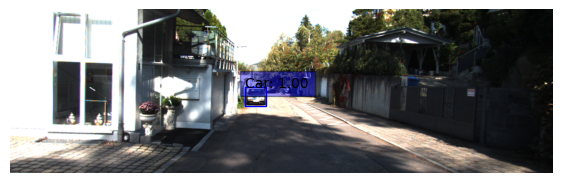

1/1 [==============================] - 0s 55ms/step


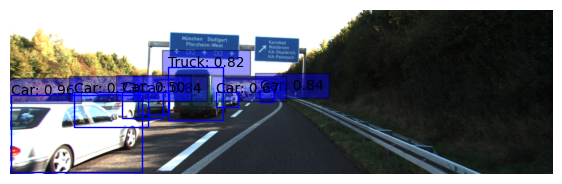

In [33]:
test_dataset = tfds.load("kitti", split="test", data_dir=DATA_PATH)
int2str = dataset_info.features["objects"]["type"].int2str

for sample in test_dataset.take(2):
    image = tf.cast(sample["image"], dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )

### 조건 테스트

이미지에 사람이 한 명 이상 있거나, 차량의 크기 (width or height) 가 300pixel 이상인 경우 -> Stop  
그 외 -> Go

1/1 [==============================] - 0s 54ms/step


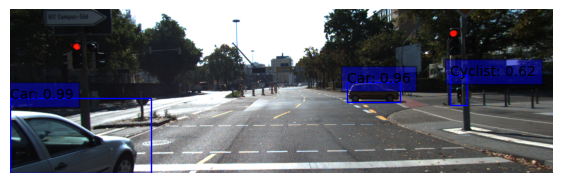

w: 317.9718322753906, h: 169.32693481445312
Stop


In [34]:
# pip install keras_retinanet
from keras_retinanet.utils.image import read_image_bgr
import cv2
import math

img_path = './images/kitti_test/stop_3.png'

def self_drive_assist(img_path, size_limit=300):
    # 코드 구현
		# 정지조건에 맞으면 return "Stop"
		# 아닌 경우 return "Go"
        
    # image to tensor
    image = read_image_bgr(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #
    image = tf.cast(image, dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    #
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )
           
    bboxes = detections.nmsed_boxes[0][:num_detections] / ratio
    #
    for detect in zip(class_names, bboxes):
        class_name = detect[0].lower()
        
        if 'pedestrian' == class_name.lower():
            return 'Stop'
        else:        
            x1, y1, x2, y2 = detect[1]
            w, h = x2 - x1, y2 - y1
            #w, h = math.ceil(w), math.ceil(h)
            print(f'w: {w}, h: {h}')
            if w >= 300.0 or h >= 300.0:
                return 'Stop'
    #
    return 'Go'

print(self_drive_assist(img_path))

### 조건 테스트 평가

1/1 [==============================] - 0s 95ms/step


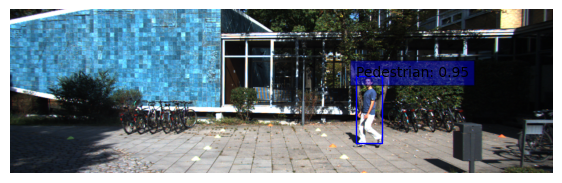

pref: Stop, answer: Stop
1/1 [==============================] - 0s 58ms/step


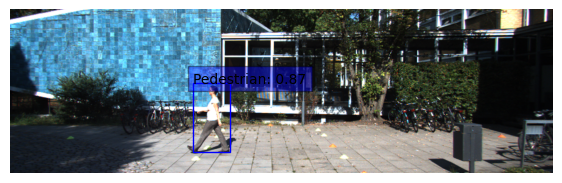

pref: Stop, answer: Stop
1/1 [==============================] - 0s 54ms/step


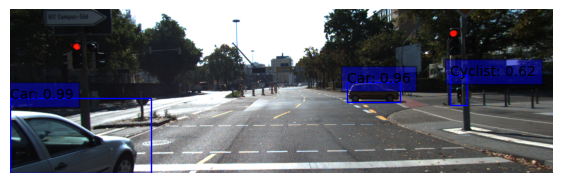

w: 317.9718322753906, h: 169.32693481445312
pref: Stop, answer: Stop
1/1 [==============================] - 0s 57ms/step


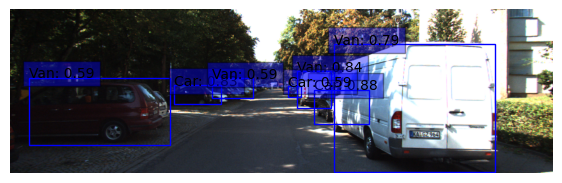

w: 125.2294921875, h: 79.30012512207031
w: 75.99969482421875, h: 85.32655334472656
w: 106.01882934570312, h: 43.2587890625
w: 370.46844482421875, h: 293.87353515625
pref: Stop, answer: Stop
1/1 [==============================] - 0s 58ms/step


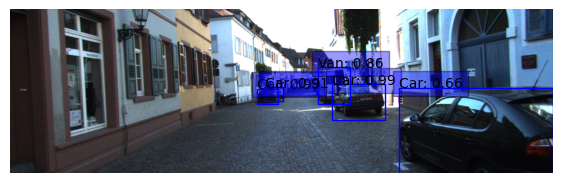

w: 48.33978271484375, h: 34.808258056640625
w: 120.78228759765625, h: 81.55927276611328
w: 41.8682861328125, h: 30.75042724609375
w: 75.0538330078125, h: 83.89323425292969
w: 353.98980712890625, h: 197.6533966064453
pref: Stop, answer: Stop
1/1 [==============================] - 0s 54ms/step


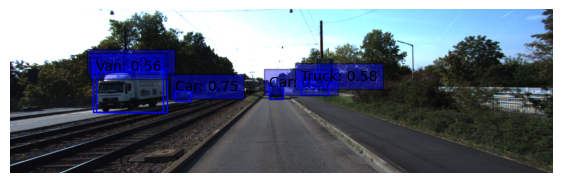

w: 32.22723388671875, h: 30.570281982421875
w: 36.64739990234375, h: 22.857421875
w: 168.66514587402344, h: 106.12419128417969
w: 61.740234375, h: 33.883941650390625
w: 155.37295532226562, h: 96.08967590332031
pref: Go, answer: Go
1/1 [==============================] - 0s 53ms/step


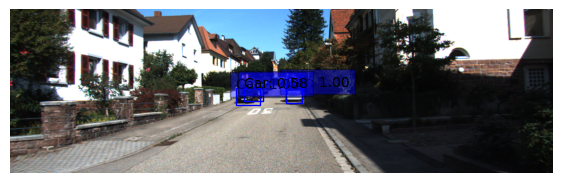

w: 37.54852294921875, h: 39.06736755371094
w: 54.83966064453125, h: 37.276824951171875
w: 42.9544677734375, h: 30.203826904296875
pref: Go, answer: Go
1/1 [==============================] - 0s 78ms/step


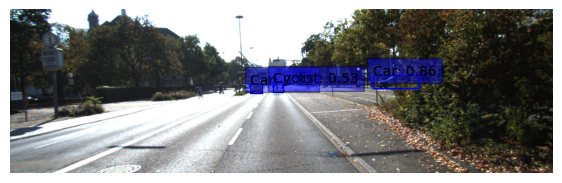

w: 104.87689208984375, h: 29.83203125
w: 27.16827392578125, h: 20.204132080078125
w: 21.16845703125, h: 21.102325439453125
pref: Go, answer: Go
1/1 [==============================] - 0s 54ms/step


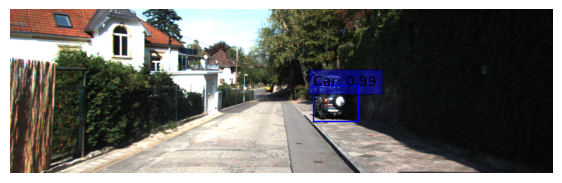

w: 103.01434326171875, h: 81.54910278320312
pref: Go, answer: Go
1/1 [==============================] - 0s 54ms/step


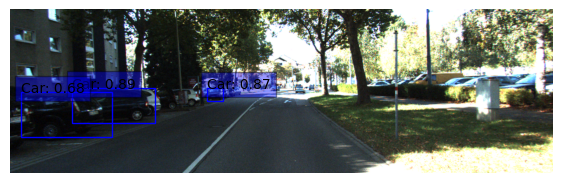

w: 190.08058166503906, h: 79.69146728515625
w: 37.591827392578125, h: 28.876510620117188
w: 208.96548461914062, h: 102.10195922851562
pref: Go, answer: Go
100점입니다.


In [35]:
import os

def test_system(func):
    work_dir = './images/kitti_test/'
    score = 0
    test_set=[
        ("stop_1.png", "Stop"),
        ("stop_2.png", "Stop"),
        ("stop_3.png", "Stop"),
        ("stop_4.png", "Stop"),
        ("stop_5.png", "Stop"),
        ("go_1.png", "Go"),
        ("go_2.png", "Go"),
        ("go_3.png", "Go"),
        ("go_4.png", "Go"),
        ("go_5.png", "Go"),
    ]
    
    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        print(f'pref: {pred}, answer: {answer}')
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

test_system(self_drive_assist)